# Problem Statement
- Task: We are developing a script for an antivirus package aimed at identifying malware before executing .exe files on Windows. Our approach involves analyzing specific properties of executable files, such as:

1. ImageBase: The preferred base address where the file's image is loaded into memory.
VersionInformationSize: The size of the version information resource, which may provide details about the file's version, company, and product name.
2. SectionsMaxEntropy: The maximum entropy value across all sections of the executable, indicating the level of randomness and potential obfuscation techniques used.
3.  My objective is to design a method to assess these properties to identify potential malware. The script should flag any .exe files that exhibit unusual or suspicious values for these properties, indicating a higher likelihood of being malicious.

In [1]:
# Installing Libraries 


!pip install lazypredict
!pip install lime

  Using cached docker-7.1.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached graphene-3.4.3-py2.py3-none-any.whl.metadata (6.9 kB)
  Using cached waitress-3.0.2-py3-none-any.whl.metadata (5.8 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached sqlparse-0.5.3-py3-none-any.whl.metadata (3.9 kB)
  Using cached mako-1.3.10-py3-none-any.whl.metadata (2.9 kB)
  Using cached graphql_core-3.2.6-py3-none-any.whl.metadata (11 kB)
  Using cached graphql_relay-3.2.0-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/24.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/24.7 MB ? eta -:--:--
   - -------------------------------------- 0.8/24.7 MB 2.2 MB/s eta 0:00:11
   -- ------------------------------------- 1.3/24.7 MB 2.5 MB/s eta 0:00:10
   --- ------------------------------------ 2.1/24.7 MB 2.9 MB/s eta 0:00:08
   ----- ---------------------------------- 3.1/24.7 MB 3.4 MB/s eta 0:00:07
   ------- ------------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import *
from sklearn.metrics import *
import lime.lime_tabular
from imblearn.over_sampling import SMOTE
from collections import Counter

In [4]:
df = pd.read_csv("Ransomware.csv" , sep='|')
df.head()

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,memtest.exe,631ea355665f28d4707448e442fbf5b8,332,224,258,9,0,361984,115712,0,6135,4096,372736,4194304.00,4096,512,0,0,0,0,1,0,1036288,1024,485887,16,1024,1048576,4096,1048576,4096,0,16,8,5.77,3.61,7.22,59712.00,1024,325120,126875.88,896,551848,0,0,0,0,4,3.26,2.57,3.54,8797.00,216,18032,0,16,1
1,ose.exe,9d10f99a6712e28f8acd5641e3a7ea6b,332,224,3330,9,0,130560,19968,0,81778,4096,143360,771751936.00,4096,512,5,1,0,0,5,1,159744,1024,188943,2,33088,1048576,4096,1048576,4096,0,16,4,4.84,2.37,6.57,35584.00,2048,130560,37322.00,1840,130296,7,181,0,0,2,4.25,3.42,5.08,837.00,518,1156,72,18,1
2,setup.exe,4d92f518527353c0db88a70fddcfd390,332,224,3330,9,0,517120,621568,0,350896,4096,811008,771751936.00,4096,512,5,1,0,0,5,1,1150976,1024,1159817,2,32832,1048576,4096,1048576,4096,0,16,4,6.41,4.89,7.60,273408.00,21504,517120,284498.00,21456,516760,14,235,21,1,11,4.43,2.85,5.27,31102.27,104,270376,72,18,1
3,DW20.EXE,a41e524f8d45f0074fd07805ff0c9b12,332,224,258,9,0,585728,369152,0,451258,4096,798720,771751936.00,4096,512,5,1,0,0,5,1,962560,1024,867570,2,33088,1048576,4096,1048576,4096,0,16,4,6.64,5.64,7.59,207872.00,15360,585728,238502.00,15208,585488,15,360,6,1,10,4.36,2.67,6.40,1457.00,90,4264,72,18,1
4,dwtrig20.exe,c87e561258f2f8650cef999bf643a731,332,224,258,9,0,294912,247296,0,217381,4096,536576,771751936.00,4096,512,5,1,0,0,5,1,552960,1024,579287,2,33088,1048576,4096,1048576,4096,0,16,4,6.25,4.18,7.61,128128.00,2560,294912,135350.00,2320,294816,10,194,4,1,2,4.31,3.42,5.19,1074.50,849,1300,72,18,1


In [5]:
# Check Data set info 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138047 entries, 0 to 138046
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Name                         138047 non-null  object 
 1   md5                          138047 non-null  object 
 2   Machine                      138047 non-null  int64  
 3   SizeOfOptionalHeader         138047 non-null  int64  
 4   Characteristics              138047 non-null  int64  
 5   MajorLinkerVersion           138047 non-null  int64  
 6   MinorLinkerVersion           138047 non-null  int64  
 7   SizeOfCode                   138047 non-null  int64  
 8   SizeOfInitializedData        138047 non-null  int64  
 9   SizeOfUninitializedData      138047 non-null  int64  
 10  AddressOfEntryPoint          138047 non-null  int64  
 11  BaseOfCode                   138047 non-null  int64  
 12  BaseOfData                   138047 non-null  int64  
 13 

In [6]:
# Check Statical Summary 

df.describe()

,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
count,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00,138047.00
mean,4259.07,225.85,4444.15,8.62,3.82,242595.56,450486.67,100952.51,171956.14,57798.45,221374.27,535087648618069.31,7323.76,694.39,5.10,1.09,68.75,64.85,4.86,1.44,815975.04,1297.88,179795931.26,2.16,22312.13,930247.73,5445.54,1031957.51,34298.82,36085.06,79087.62,4.99,4.64,2.26,6.96,187151.28,19564.88,650680.51,188423.73,21098.37,634980.81,5.46,113.23,4.34,23.67,22.05,4.00,2.43,5.52,55450.93,18180.82,246590.25,465674.98,12.36,0.30
std,10880.35,5.12,8186.78,4.09,11.86,5754485.40,21015985.18,16352876.18,3430552.50,5527658.05,2188020.09,99295894357901104.00,625768.69,1289.92,99.22,77.55,1185.89,1139.69,0.65,181.18,6530064.85,5595.52,597619186.41,0.45,15440.57,555008.06,18047.24,181774.40,7906877.49,8904748.09,14669006.50,1.92,1.10,1.83,1.04,7735218.22,354086.82,30072259.74,4180152.82,354314.11,12854626.76,4.36,123.13,34.78,252.09,136.49,1.11,0.82,1.60,7799163.38,6502369.19,21248603.86,26089866.93,6.80,0.46
min,332.00,224.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,65536.00,16.00,16.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,448.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00,1.00,0.00,0.00,0.00,64.00,0.00,64.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,332.00,224.00,258.00,8.00,0.00,30208.00,24576.00,0.00,12721.00,4096.00,28672.00,4194304.00,4096.00,512.00,4.00,0.00,0.00,0.00,4.00,0.00,184320.00,1024.00,106576.50,2.00,320.00,1048576.00,4096.00,1048576.00,4096.00,0.00,16.00,4.00,4.00,0.02,6.42,18688.00,512.00,57344.00,35872.00,364.00,108504.00,3.00,67.00,0.00,0.00,5.00,3.46,2.18,4.83,956.00,48.00,2216.00,0.00,13.00,0.00
50%,332.00,224.00,258.00,9.00,0.00,113664.00,263168.00,0.00,52883.00,4096.00,114688.00,4194304.00,4096.00,512.00,5.00,1.00,0.00,0.00,5.00,1.00,516096.00,1024.00,518026.00,2.00,33088.00,1048576.00,4096.00,1048576.00,4096.00,0.00,16.00,5.00,4.89,2.55,6.69,88473.60,3584.00,252928.00,101043.00,4764.00,330808.00,4.00,90.00,0.00,0.00,6.00,3.73,2.46,5.32,2708.15,48.00,9640.00,72.00,15.00,0.00
75%,332.00,224.00,8226.00,10.00,0.00,120320.00,385024.00,0.00,61578.00,4096.00,126976.00,100335616.00,4096.00,512.00,5.00,1.00,6.00,0.00,5.00,1.00,528384.00,1024.00,571630.50,2.00,33088.00,1048576.00,4096.00,1048576.00,4096.00,0.00,16.00,5.00,5.64,4.09,7.96,101068.80,9728.00,330752.00,102635.80,9400.00,339716.00,8.00,128.00,1.00,0.00,13.00,4.23,2.70,6.50,6558.43,132.00,23780.00,72.00,16.00,1.00
max,34404.00,352.00,49551.00,255.00,255.00,1818586738.00,4294966272.00,4294940713.00,1074484297.00,2028711251.00,268

In [7]:
# Check shape 

df.shape 

(138047, 57)

In [8]:
# Check Null values 

df.isnull().sum()

Name                           0
md5                            0
Machine                        0
SizeOfOptionalHeader           0
Characteristics                0
MajorLinkerVersion             0
MinorLinkerVersion             0
SizeOfCode                     0
SizeOfInitializedData          0
SizeOfUninitializedData        0
AddressOfEntryPoint            0
BaseOfCode                     0
BaseOfData                     0
ImageBase                      0
SectionAlignment               0
FileAlignment                  0
MajorOperatingSystemVersion    0
MinorOperatingSystemVersion    0
MajorImageVersion              0
MinorImageVersion              0
MajorSubsystemVersion          0
MinorSubsystemVersion          0
SizeOfImage                    0
SizeOfHeaders                  0
CheckSum                       0
Subsystem                      0
DllCharacteristics             0
SizeOfStackReserve             0
SizeOfStackCommit              0
SizeOfHeapReserve              0
SizeOfHeap

- No null values in dataset. 

In [9]:
# Check Duplicate Records 

df.duplicated().sum()

0

- No Duplicate Values .

In [11]:
df['legitimate'].value_counts()

legitimate
0    96724
1    41323
Name: count, dtype: int64

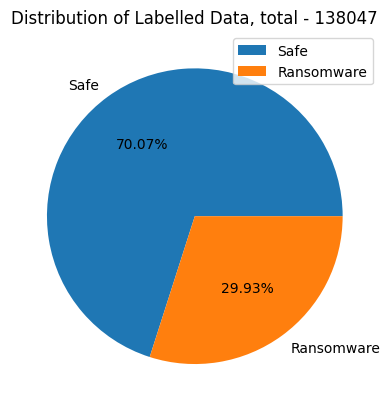

In [12]:
plt.pie(df.legitimate.value_counts().values.tolist(), labels=['Safe','Ransomware'], autopct='%.2f%%')
plt.legend()
plt.title(f"Distribution of Labelled Data, total - {len(df)}")
plt.show()

In [13]:
df.md5.nunique()


138047

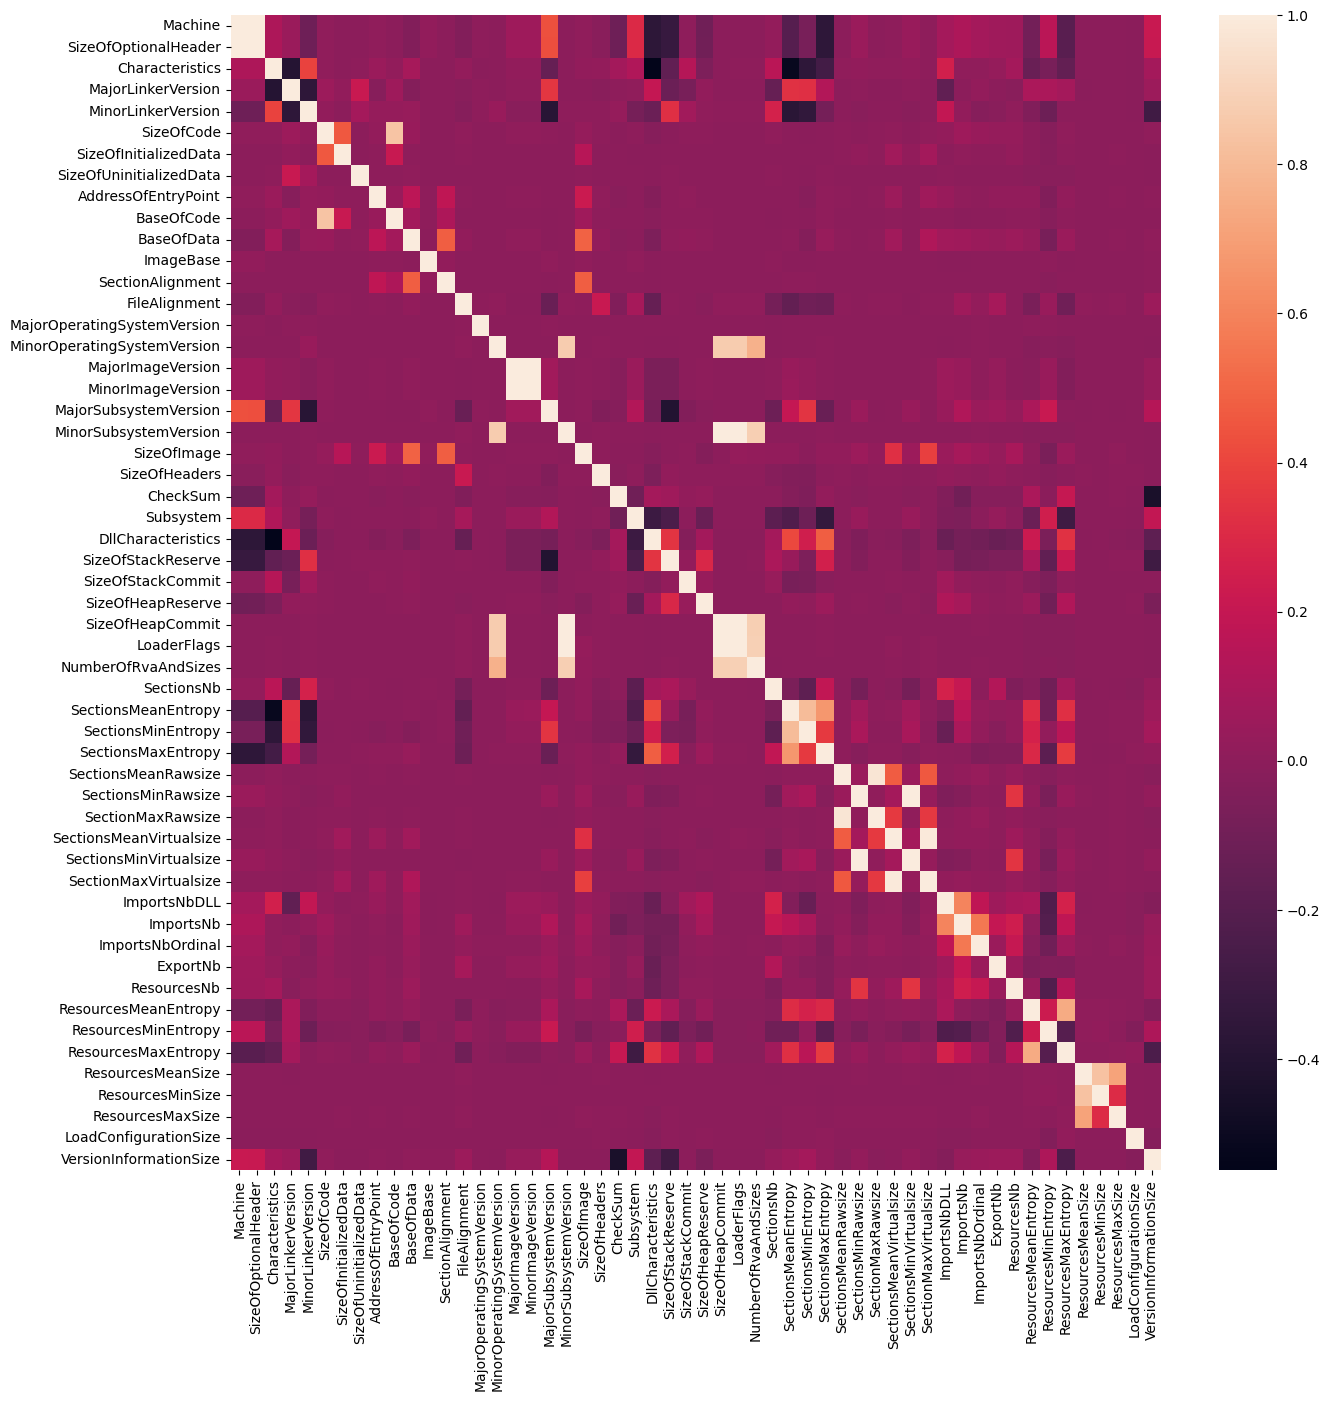

In [15]:
# Correlation b/w independent columns/attributes
plt.figure(figsize=(15,15))
sns.heatmap(df.drop(['Name','md5','legitimate'], axis=1).corr())
plt.show()

# Most Relevant Features for Prediction using IV and WoE

In [16]:
def iv_woe(data, target, bins=10, show_woe=False):
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [17]:
iv, woe = iv_woe(df.drop(['Name','md5'],axis=1), 'legitimate')


Information value of Machine is 2.596527
Information value of SizeOfOptionalHeader is 2.596853
Information value of Characteristics is 3.823743
Information value of MajorLinkerVersion is 2.787002
Information value of MinorLinkerVersion is 0.583745
Information value of SizeOfCode is 2.5136
Information value of SizeOfInitializedData is 3.569039
Information value of SizeOfUninitializedData is 0.328101
Information value of AddressOfEntryPoint is 2.351206
Information value of BaseOfCode is 0.031301
Information value of BaseOfData is 2.974971
Information value of ImageBase is 6.097249
Information value of SectionAlignment is 0.163236
Information value of FileAlignment is 0.153303
Information value of MajorOperatingSystemVersion is 4.34342
Information value of MinorOperatingSystemVersion is 0.475603
Information value of MajorImageVersion is 0.181241
Information value of MinorImageVersion is 0.17365
Information value of MajorSubsystemVersion is 3.566766
Information value of MinorSubsystemVersi

In [18]:
iv.sort_values(by = 'IV', ascending=False)


,Variable,IV
0,ImageBase,6.10
0,VersionInformationSize,5.19
0,SectionsMaxEntropy,4.98
0,MajorOperatingSystemVersion,4.34
0,ResourcesMinSize,4.27
0,SizeOfStackReserve,4.16
0,Characteristics,3.82
0,SizeOfInitializedData,3.57
0,MajorSubsystemVersion,3.57
0,SectionsMinVirtualsize,3.39


In [22]:
thresh = 1
res = len(iv)-len(iv[iv['IV']>thresh]) 
print(res) # Total 17 features which are relevant (greater than threshold)

17


In [20]:
features = iv.sort_values(by = 'IV', ascending=False)['Variable'][:res].values.tolist()


In [21]:
print(features,'\n')
print('Total number of features-\n',len(features))

['ImageBase', 'VersionInformationSize', 'SectionsMaxEntropy', 'MajorOperatingSystemVersion', 'ResourcesMinSize', 'SizeOfStackReserve', 'Characteristics', 'SizeOfInitializedData', 'MajorSubsystemVersion', 'SectionsMinVirtualsize', 'ResourcesNb', 'Subsystem', 'ResourcesMinEntropy', 'BaseOfData', 'SizeOfImage', 'MajorLinkerVersion', 'ExportNb'] 

Total number of features-
 17


# Training Machine Learning Model


In [23]:
X = df[features]
y = df['legitimate']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)


In [25]:
print(X_test.shape[0] + X_train.shape[0])
print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)
print('Training features shape:', X_train.shape)
print('Test features shape:', X_test.shape)

138047
Training labels shape: (96632,)
Test labels shape: (41415,)
Training features shape: (96632, 17)
Test features shape: (41415, 17)


# Lazy Predict - AutoML

In [27]:
rf = RandomForestClassifier(random_state = 42)

In [28]:
rf.fit(X_train,y_train)


RandomForestClassifier(random_state=42)

In [29]:
pred = rf.predict(X_test)
pred_proba = rf.predict_proba(X_test)

# Extract probabilities for the positive class (1)
pred_proba = np.array([prob[1] for prob in pred_proba])

In [32]:
cm = confusion_matrix(y_test,pred)
cm

array([[28789,   145],
       [  105, 12376]], dtype=int64)

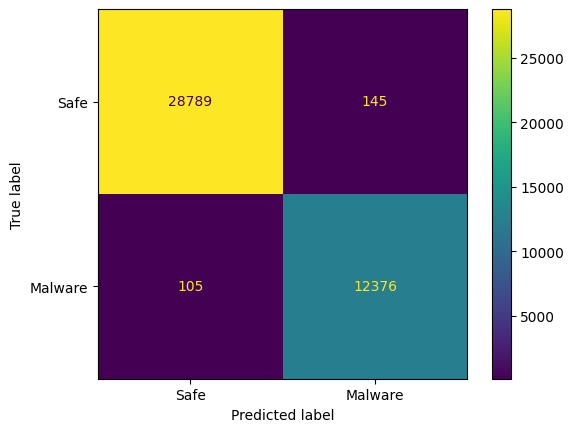

In [33]:
classes = ['Safe', 'Malware']

cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot()
plt.show()

In [34]:
TP = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]
TN = cm[0, 0]

In [35]:
# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Precision
precision = TP / (TP + FP)

# Recall
recall = TP / (TP + FN)

# F1 Score
f1 = 2 * (precision * recall) / (precision + recall)

# Matthews Correlation Coefficient (MCC)
mcc = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

# False Positive Rate (FPR)
fpr = FP / (FP + TN)

# Calculate AUC score
auc = roc_auc_score(y_test, pred_proba)

# Print all the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"False Positive Rate: {fpr:.4f}")
print(f"AUC Score: {auc:.4f}")

Accuracy: 0.9940
Precision: 0.9884
Recall: 0.9916
F1 Score: 0.9900
MCC: 0.9857
False Positive Rate: 0.0050
AUC Score: 0.9996
